In [2]:
# Importing libraries

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Obtaining data

ticker = "AAPL"
data = yf.download(ticker, period="2y", auto_adjust=True)
price = data["Close"]
price.tail()

[*********************100%***********************]  1 of 1 completed


Ticker,AAPL
Date,
2025-10-28,269.000000
2025-10-29,269.700012
2025-10-30,271.399994
2025-10-31,270.369995
2025-11-03,269.049988


In [4]:
# Rolling mean and rolling volatility

window = 20 # classic Bollinger window (aprox 1 trading month)

ma20 = price.rolling(window).mean() # 20-day simple moving average
sd20 = price.rolling(window).std() # 20-day rolling standard deviation (volatility)

df_p_ma_sd = pd.concat([price, ma20, sd20], axis=1).tail()

cols = list(df_p_ma_sd.columns)
cols[1] = "Moving Avg."   # change the 2nd one
cols[2] = "Standard Dev." # change the thrid one
df_p_ma_sd.columns = cols

df_p_ma_sd

,AAPL,Moving Avg.,Standard Dev.
Date,,,
2025-10-28,269.000000,256.465999,6.793765
2025-10-29,269.700012,257.178500,7.401647
2025-10-30,271.399994,257.891999,8.055630
2025-10-31,270.369995,258.509499,8.525590
2025-11-03,269.049988,259.127499,8.829320


In [5]:
# Bollinger Bands 

k = 2 # band width
upper = ma20 + k*sd20
lower = ma20 - k*sd20

In [6]:
# Crossing: when price exits/enters the band

price = price.squeeze("columns")
ma20  = ma20.squeeze("columns")
upper = upper.squeeze("columns")
lower = lower.squeeze("columns")

# booleans for above/below
above = (price > upper)
below = (price < lower)

# crossing points (change from False to True or True to False)
cross_above = above & (above.shift(1))  # just crossed ABOVE upper
cross_below = below & (below.shift(1))  # just crossed BELOW lower

signals = pd.DataFrame({
    "price": price, "ma20": ma20,
    "upper": upper, "lower": lower,
    "cross_above": cross_above,
    "cross_below": cross_below
}, index=price.index)

signals.tail()

,price,ma20,upper,lower,cross_above,cross_below
Date,,,,,,
2025-10-28,269.000000,256.465999,270.053528,242.878469,False,False
2025-10-29,269.700012,257.178500,271.981794,242.375205,False,False
2025-10-30,271.399994,257.891999,274.003258,241.780740,False,False
2025-10-31,270.369995,258.509499,275.560680,241.458319,False,False
2025-11-03,269.049988,259.127499,276.786138,241.468859,False,False


In [7]:
# Debugging
for name, obj in {"price":price,"ma20":ma20,"upper":upper,"lower":lower,
                  "cross_above":cross_above,"cross_below":cross_below}.items():
    print(name, type(obj), getattr(obj, "shape", None))


price <class 'pandas.core.series.Series'> (500,)
ma20 <class 'pandas.core.series.Series'> (500,)
upper <class 'pandas.core.series.Series'> (500,)
lower <class 'pandas.core.series.Series'> (500,)
cross_above <class 'pandas.core.series.Series'> (500,)
cross_below <class 'pandas.core.series.Series'> (500,)


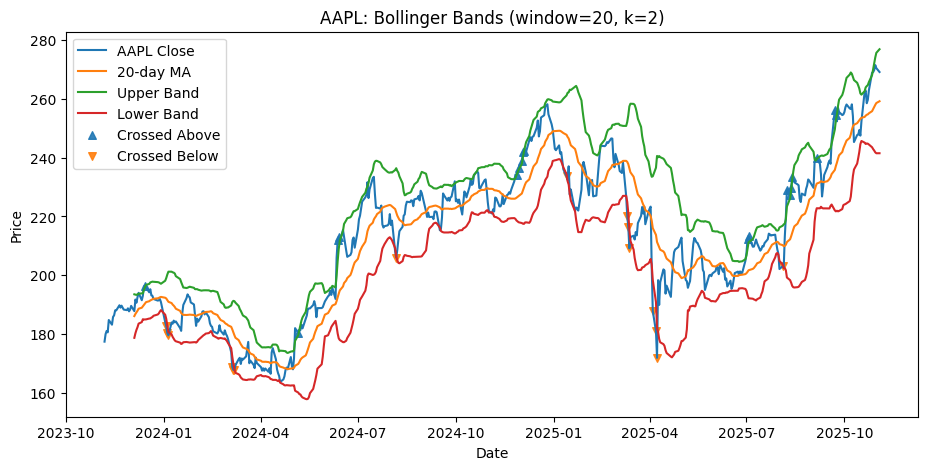

In [8]:
# Plot and annotate

plt.figure(figsize=(11,5))
plt.plot(price.index, price.values, label=f"{ticker} Close")
plt.plot(ma20.index, ma20.values, label="20-day MA")
plt.plot(upper.index, upper.values, label="Upper Band")
plt.plot(lower.index, lower.values, label="Lower Band")

# annotate crossings
plt.scatter(price.index[cross_above], price[cross_above], s=30, marker="^", label="Crossed Above", alpha=0.9)
plt.scatter(price.index[cross_below], price[cross_below], s=30, marker="v", label="Crossed Below", alpha=0.9)

plt.title(f"{ticker}: Bollinger Bands (window={window}, k={k})")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend()
plt.show()

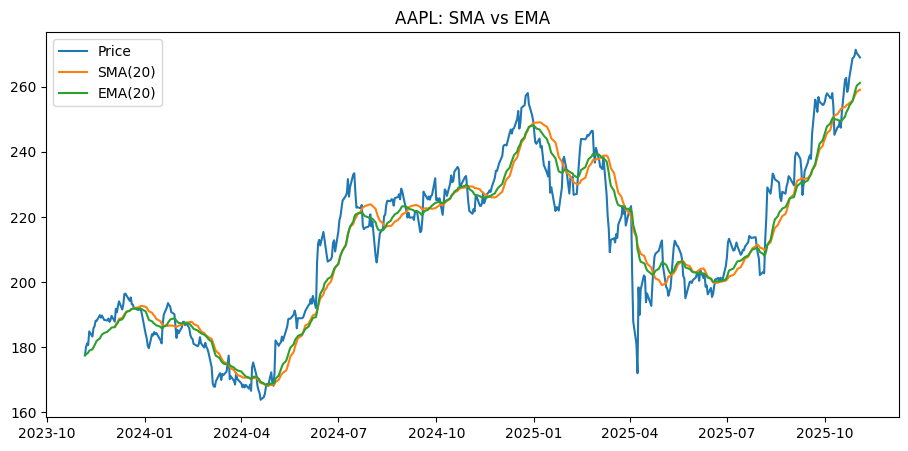

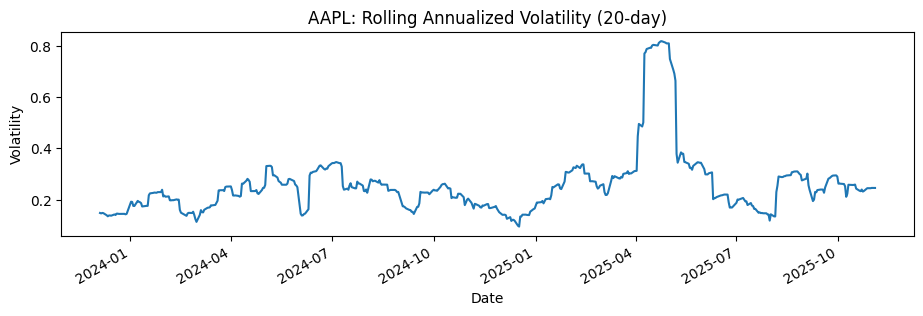

In [12]:
# Exponential Moving Average (EMA) & rolling annualizaed vol

ema20 = price.ewm(span=20, adjust=False).mean()

# daily returns & annualized rolling volatility (sqr(252) * sigma_d)

ret = price.pct_change()
roll_vol_ann = (ret.rolling(window).std() * np.sqrt(252))

fig, ax = plt.subplots(figsize=(11,5))
ax.plot(price.index, price, label="Price")
ax.plot(ma20.index, ma20, label="SMA(20)")
ax.plot(ema20.index, ema20, label="EMA(20)")
ax.set_title(f"{ticker}: SMA vs EMA")
ax.legend()
plt.show()

roll_vol_ann.plot(figsize=(11,3), title=f"{ticker}: Rolling Annualized Volatility ({window}-day)")
plt.ylabel("Volatility")
plt.show()